# Part 3:Time-Series Forecasting using RNN

In [1]:
# Import libraries
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
import torch
import torch.nn as nn
import torch.optim as optim
import time
import torch.nn.functional as F

## Read, Preprocess and main statistics

In [ ]:
# Read Data
csv_file_name = "household_power_consumption.txt"

dataset = pd.read_csv(csv_file_name, sep=';',
                 parse_dates={'DateTime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 index_col='DateTime')

In [2]:
dataset.head()

<ipython-input-2-16d2b5b10a68>:5: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_name, sep=';',


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97195 entries, 2006-12-16 17:24:00 to 2007-02-22 05:01:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    97194 non-null  object 
 1   Global_reactive_power  97194 non-null  object 
 2   Voltage                97194 non-null  object 
 3   Global_intensity       97194 non-null  object 
 4   Sub_metering_1         97194 non-null  object 
 5   Sub_metering_2         97194 non-null  object 
 6   Sub_metering_3         97188 non-null  float64
dtypes: float64(1), object(6)
memory usage: 5.9+ MB


In [ ]:
# Convert object columns to numeric
dataset['Global_active_power'] = pd.to_numeric(dataset['Global_active_power'], errors='coerce')
dataset['Global_reactive_power'] = pd.to_numeric(dataset['Global_reactive_power'], errors='coerce')
dataset['Voltage'] = pd.to_numeric(dataset['Voltage'], errors='coerce')
dataset['Global_intensity'] = pd.to_numeric(dataset['Global_intensity'], errors='coerce')
dataset['Sub_metering_1'] = pd.to_numeric(dataset['Sub_metering_1'], errors='coerce')
dataset['Sub_metering_2'] = pd.to_numeric(dataset['Sub_metering_2'], errors='coerce')

In [4]:
# Check the data types
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97195 entries, 2006-12-16 17:24:00 to 2007-02-22 05:01:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    97188 non-null  float64
 1   Global_reactive_power  97188 non-null  float64
 2   Voltage                97188 non-null  float64
 3   Global_intensity       97188 non-null  float64
 4   Sub_metering_1         97188 non-null  float64
 5   Sub_metering_2         97188 non-null  float64
 6   Sub_metering_3         97188 non-null  float64
dtypes: float64(7)
memory usage: 5.9 MB
None


In [5]:
dataset.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [6]:
dataset.shape

(97195, 7)

In [7]:
# null check
dataset.isnull().sum()

Global_active_power      7
Global_reactive_power    7
Voltage                  7
Global_intensity         7
Sub_metering_1           7
Sub_metering_2           7
Sub_metering_3           7
dtype: int64

In [8]:
dataset.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,97188.000000,97188.00000,97188.000000,97188.000000,97188.000000,97188.000000,97188.000000
mean,1.651759,0.12924,240.849239,6.983436,1.339548,1.917438,7.489762
std,1.340672,0.11765,3.471399,5.651624,6.750034,7.628342,8.664770
min,0.194000,0.00000,224.680000,0.800000,0.000000,0.000000,0.000000
25%,0.398000,0.00000,238.530000,1.800000,0.000000,0.000000,0.000000
50%,1.422000,0.11600,241.090000,5.800000,0.000000,0.000000,0.000000
75%,2.422000,0.19800,243.330000,10.000000,0.000000,1.000000,17.000000
max,9.272000,0.87400,251.700000,40.400000,77.000000,78.000000,20.000000


In [9]:
# Fill missing values with the mean
dataset['Global_active_power'].fillna(dataset['Global_active_power'].mean(), inplace=True)
dataset['Global_reactive_power'].fillna(dataset['Global_reactive_power'].mean(), inplace=True)
dataset['Voltage'].fillna(dataset['Voltage'].mean(), inplace=True)
dataset['Global_intensity'].fillna(dataset['Global_intensity'].mean(), inplace=True)
dataset['Sub_metering_1'].fillna(dataset['Sub_metering_1'].mean(), inplace=True)
dataset['Sub_metering_2'].fillna(dataset['Sub_metering_2'].mean(), inplace=True)
dataset['Sub_metering_3'].fillna(dataset['Sub_metering_3'].mean(), inplace=True)

In [10]:
resampled_df = dataset.resample('D').mean()
print(resampled_df.head())

            Global_active_power  Global_reactive_power     Voltage  \
DateTime                                                             
2006-12-16             3.053475               0.088187  236.243763   
2006-12-17             2.354486               0.156949  240.087028   
2006-12-18             1.530435               0.112356  241.231694   
2006-12-19             1.157079               0.104821  241.999313   
2006-12-20             1.545658               0.111804  242.308062   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
DateTime                                                                      
2006-12-16         13.082828        0.000000        1.378788       12.439394  
2006-12-17          9.999028        1.411806        2.907639        9.264583  
2006-12-18          6.421667        0.738194        1.820139        9.734722  
2006-12-19          4.926389        0.582639        5.279167        4.303472  
2006-12-20          6.467361       

## Data Visualization

<Figure size 2000x1000 with 0 Axes>

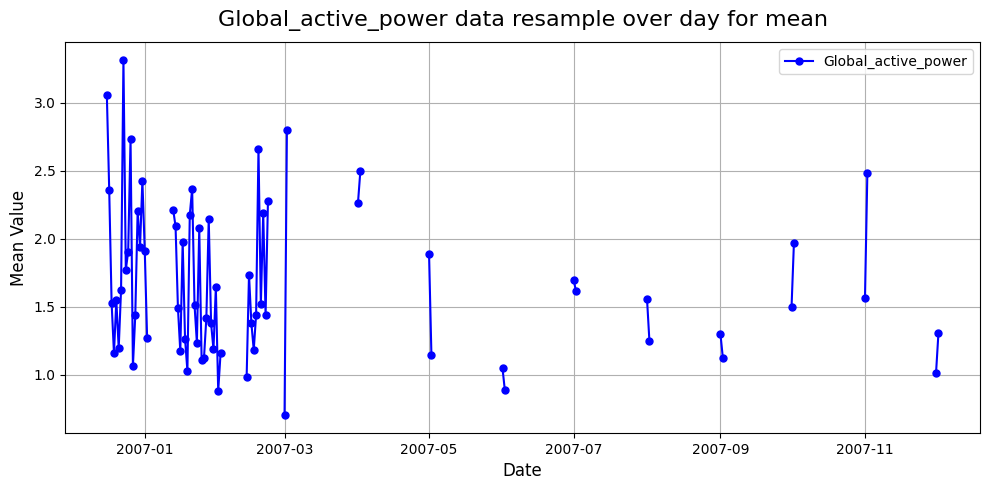

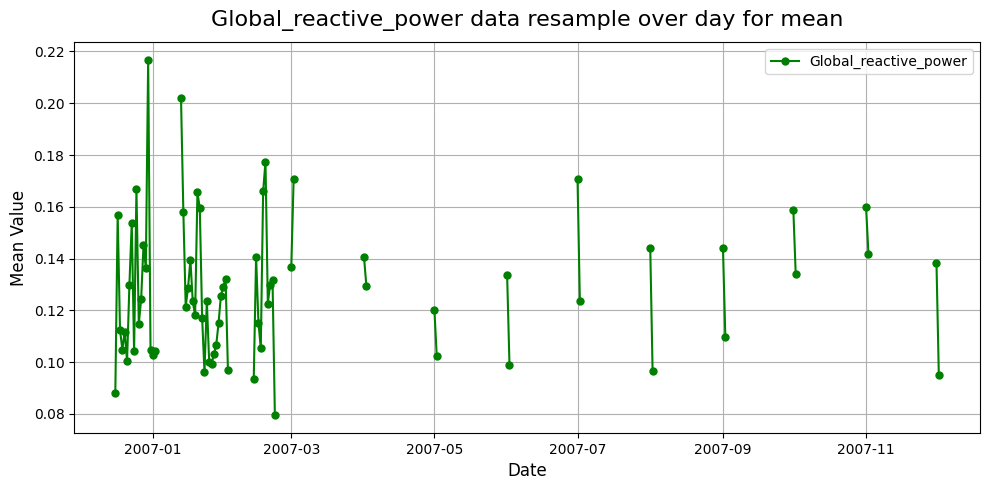

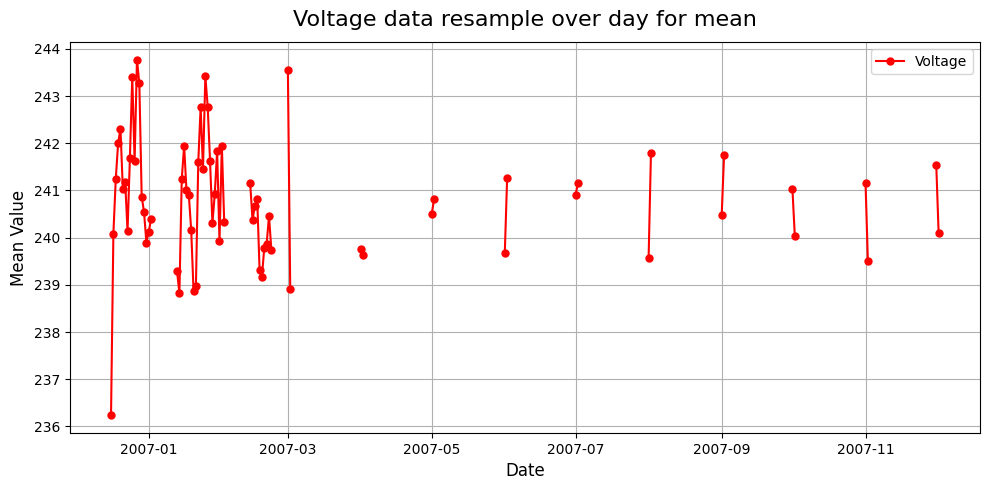

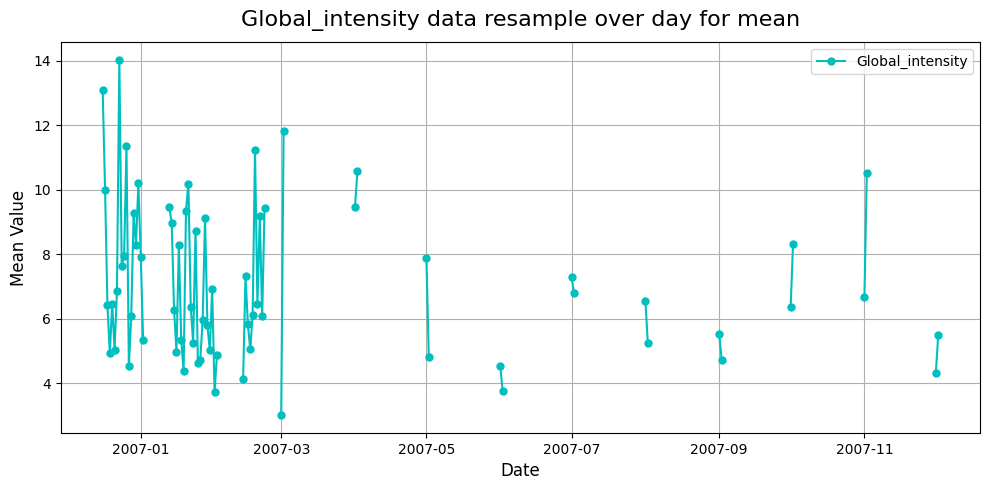

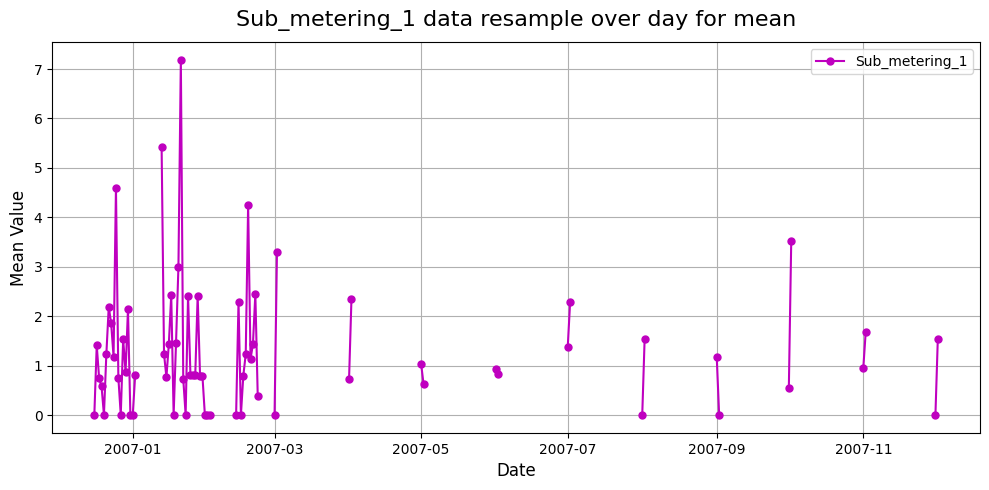

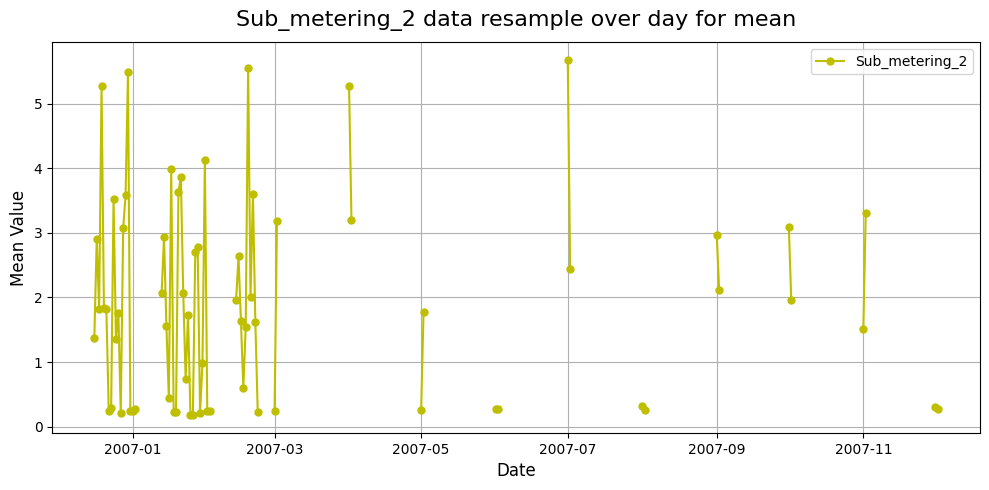

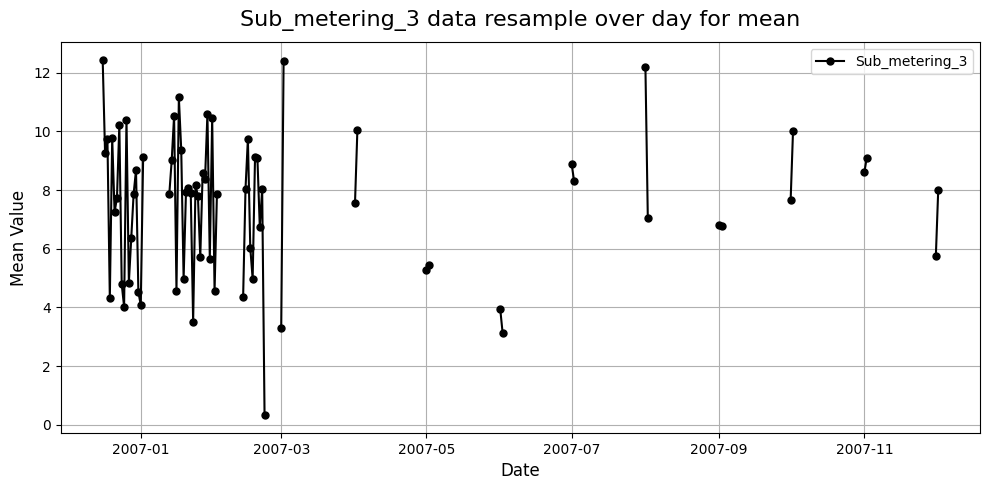

In [11]:
plt.figure(figsize=(20, 10))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, col in enumerate(resampled_df.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(resampled_df[col], label=col, color=colors[i % len(colors)], marker='o', markersize=5)
    plt.title(col + ' data resample over day for mean', y=1.02, loc='center', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Mean Value', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


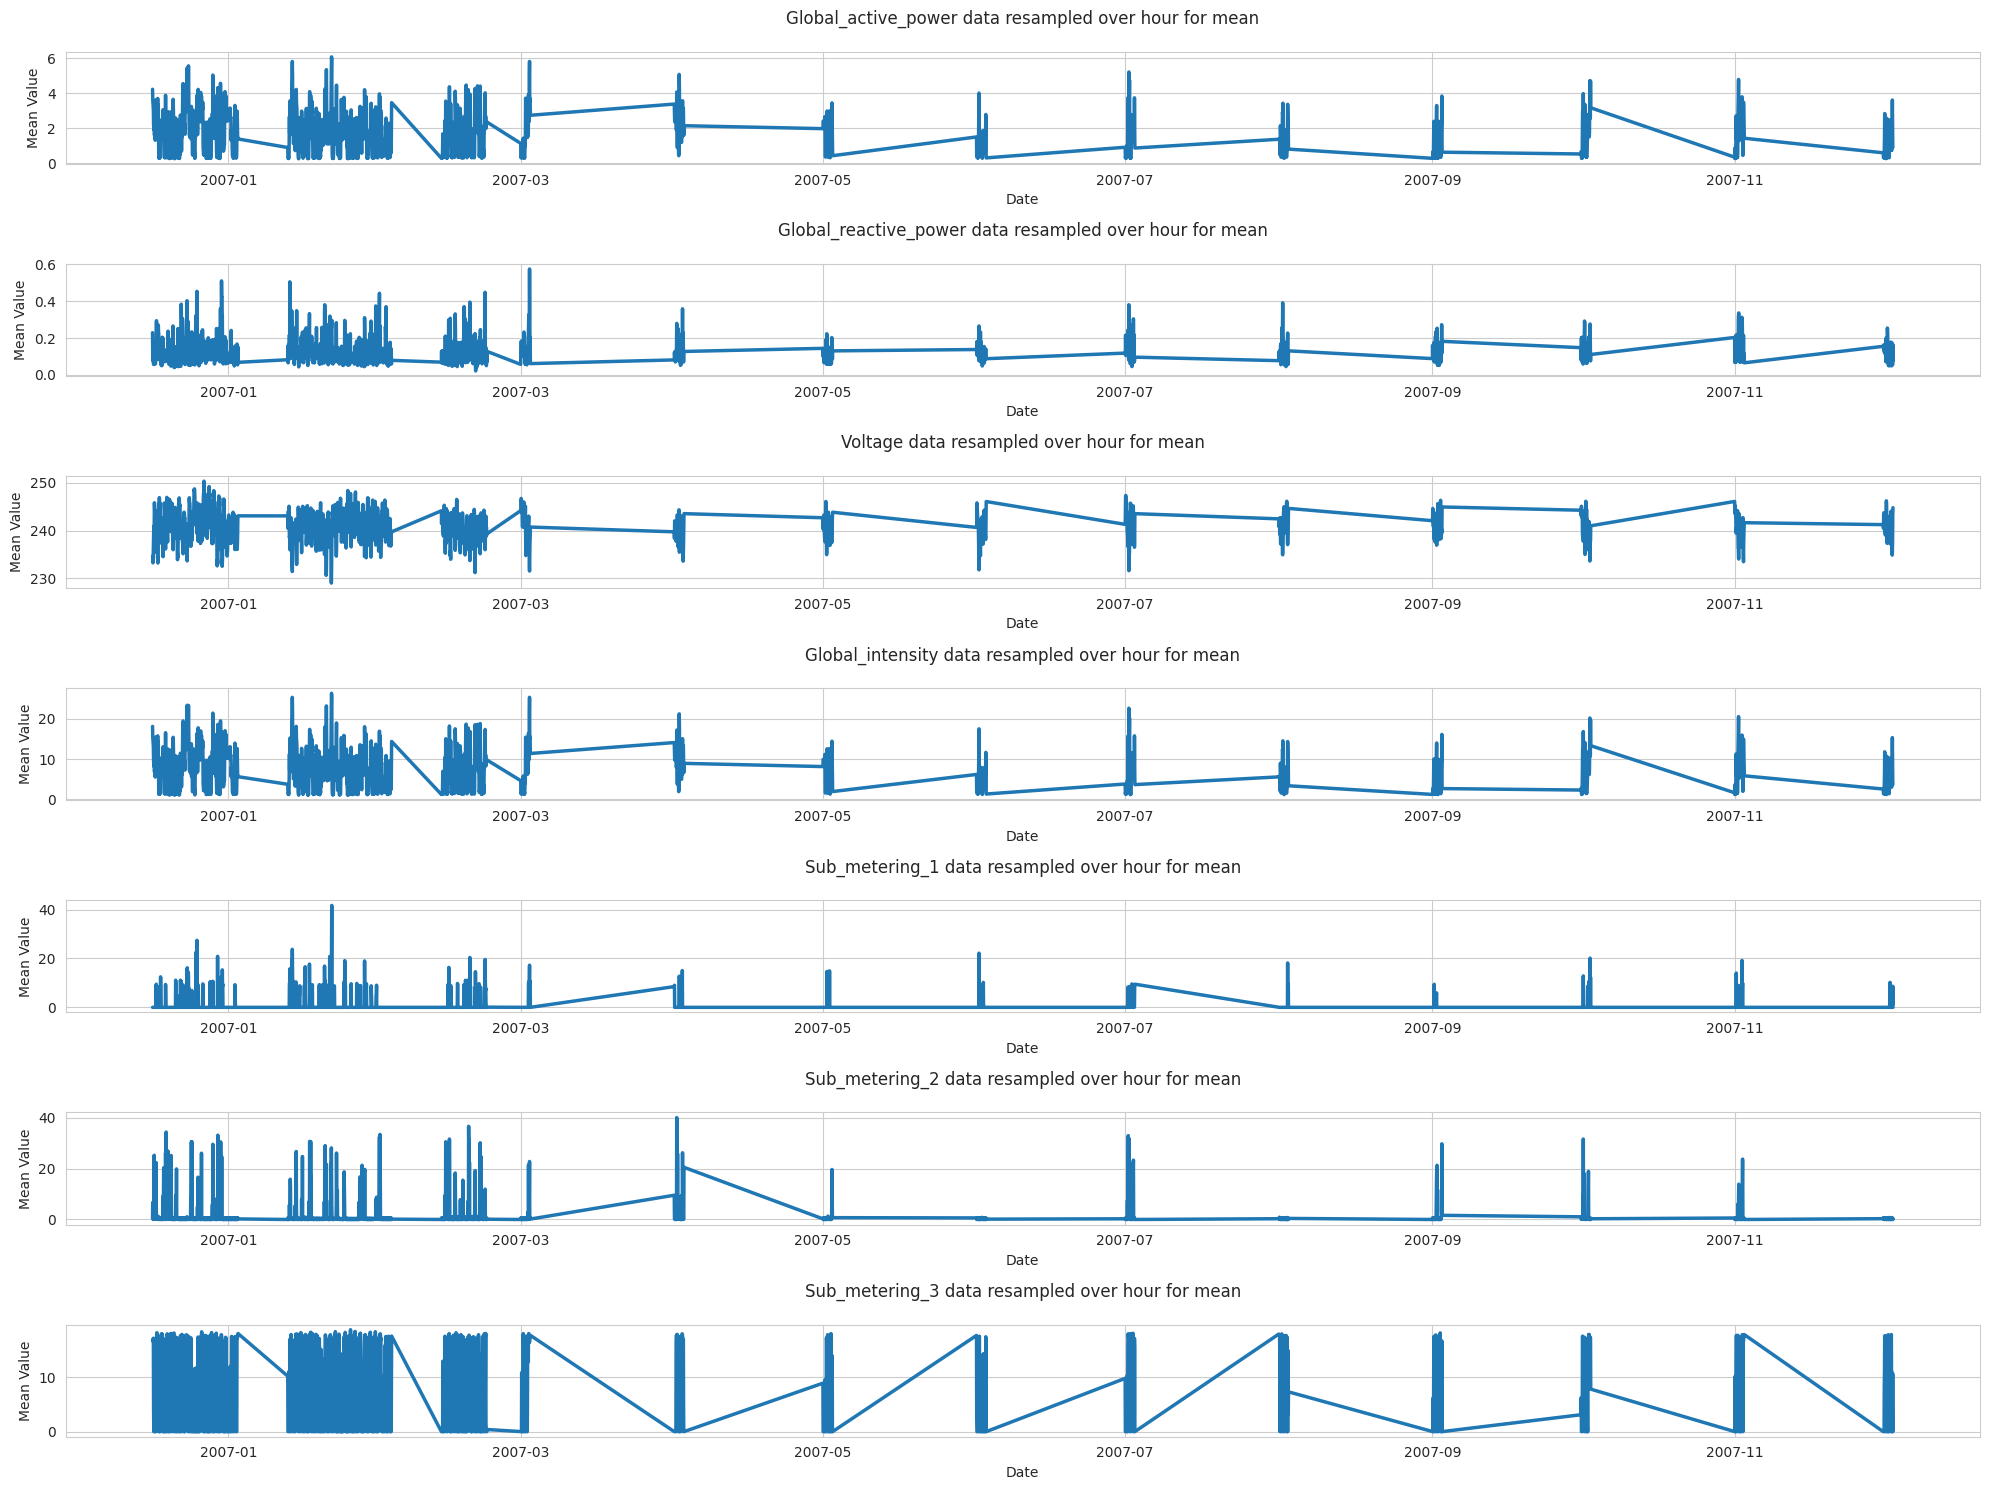

In [12]:
sns.set_style("whitegrid")
resampled_df = df.resample('H').mean()
num_cols = resampled_df.shape[1]

plt.figure(figsize=(20, 15)) 
plt.subplots_adjust(hspace=0.5)

for col in range(num_cols):
    ax = plt.subplot(num_cols, 1, col+1)
    sns.lineplot(data=resampled_df.iloc[:, col], linewidth=2.5)
    ax.set_title(resampled_df.columns[col] + ' data resampled over hour for mean', pad=20) 
    plt.xlabel('Date')
    plt.ylabel('Mean Value')
plt.tight_layout()
plt.show()

<ipython-input-13-d56aceb75067>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=resampled_df[col], palette='Set3')
<ipython-input-13-d56aceb75067>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=resampled_df[col], palette='Set3')
<ipython-input-13-d56aceb75067>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=resampled_df[col], palette='Set3')
<ipython-input-13-d56aceb75067>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set

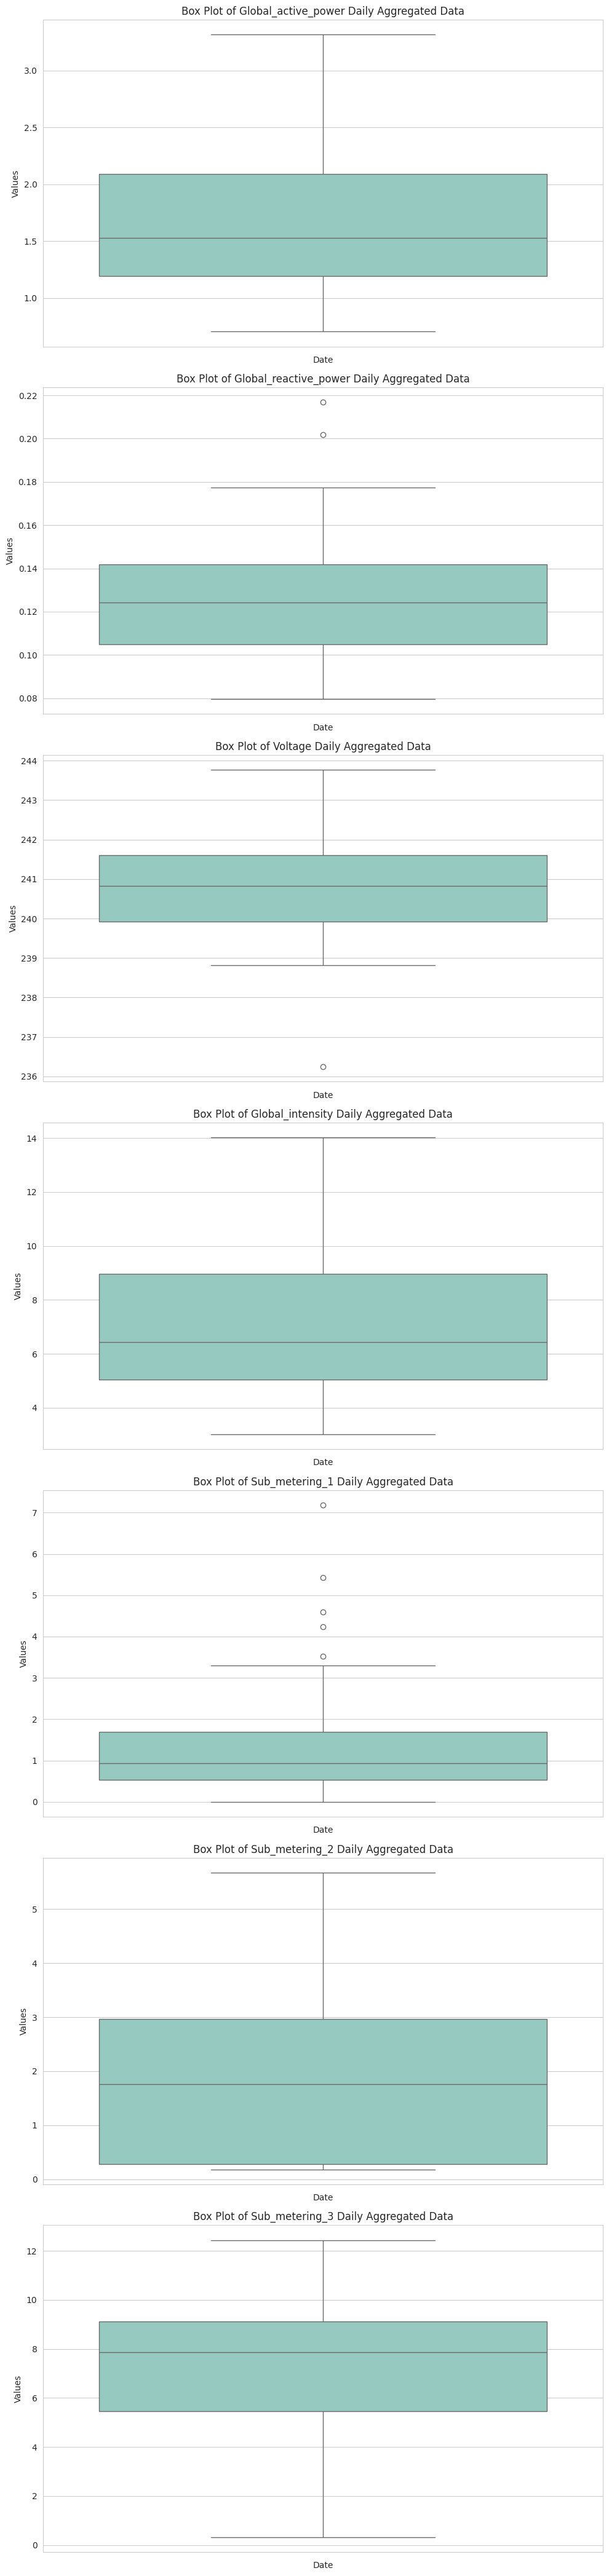

In [13]:
resampled_df = df.resample('D').mean()
num_cols = resampled_df.shape[1]
plt.figure(figsize=(10, 6*num_cols))

for i, col in enumerate(resampled_df.columns):
    plt.subplot(num_cols, 1, i+1)
    sns.boxplot(data=resampled_df[col], palette='Set3')
    plt.title('Box Plot of ' + col + ' Daily Aggregated Data')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.xticks(rotation=45, ha='right') 

plt.tight_layout()
plt.show()

In [14]:
import pandas as pd

def supervised(data, n_in=1, n_out=1, dropnan=True):
  
    df = pd.DataFrame(data)
    cols, names = [], []

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{df.columns[j]}(t-{i})' for j in range(df.shape[1])]

    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'{df.columns[j]}(t)' for j in range(df.shape[1])]
        else:
            names += [f'{df.columns[j]}(t+{i})' for j in range(df.shape[1])]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [15]:
df_resampled = df.resample('h').mean()
df_resampled.shape

(8431, 7)

In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df_resampled)

df_scaled =pd.DataFrame(scaled)
df_scaled

,0,1,2,3,4,5,6
0,0.682185,0.375233,0.264248,0.675010,0.000000,0.013178,0.897663
1,0.580911,0.106453,0.261262,0.576209,0.000000,0.167707,0.897959
2,0.541140,0.115836,0.198100,0.532868,0.000000,0.035789,0.888199
3,0.518565,0.097552,0.237422,0.509683,0.000000,0.000000,0.893523
4,0.482201,0.100379,0.382109,0.475300,0.000000,0.010404,0.916593
...,...,...,...,...,...,...,...
8426,0.344897,0.271967,0.274322,0.341589,0.000000,0.007907,0.000000
8427,0.576344,0.105912,0.293710,0.565143,0.192323,0.011236,0.578527
8428,0.361785,0.059722,0.424118,0.350020,0.028389,0.000000,0.184561
8429,0.120759,0.260360,0.683825,0.121460,0.206717,0.013733,0.000000


In [17]:
reframed = supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)

In [18]:
reframed=reframed.rename(columns = {'var1(t)': 'target'}, inplace = False)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),target
0,0.580911,0.106453,0.261262,0.576209,0.0,0.167707,0.897959,0.682185
1,0.541140,0.115836,0.198100,0.532868,0.0,0.035789,0.888199,0.580911
2,0.518565,0.097552,0.237422,0.509683,0.0,0.000000,0.893523,0.541140
3,0.482201,0.100379,0.382109,0.475300,0.0,0.010404,0.916593,0.518565
4,0.335381,0.063391,0.457159,0.336056,0.0,0.003329,0.236025,0.482201


In [19]:
# Extract feature columns (X) and target column (y)
X = reframed.drop(columns=['target'])  # Drop the 'target' column to get features
y = reframed['target']  # Select only the 'target' column for the target variable

In [20]:
X.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1)
0,0.580911,0.106453,0.261262,0.576209,0.0,0.167707,0.897959
1,0.541140,0.115836,0.198100,0.532868,0.0,0.035789,0.888199
2,0.518565,0.097552,0.237422,0.509683,0.0,0.000000,0.893523
3,0.482201,0.100379,0.382109,0.475300,0.0,0.010404,0.916593
4,0.335381,0.063391,0.457159,0.336056,0.0,0.003329,0.236025


In [21]:
y.head()

0    0.682185
1    0.580911
2    0.541140
3    0.518565
4    0.482201
Name: target, dtype: float64

In [22]:
# Split the data into train, validate and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False, random_state=42)

X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Print the shapes of the data
print("Train shapes:")
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("Validation shapes:")
print("X_val.shape:", X_val.shape)
print("y_val.shape:", y_val.shape)
print("Test shapes:")
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)


Train shapes:
X_train.shape: (1157, 1, 7)
y_train.shape: (1157,)
Validation shapes:
X_val.shape: (129, 1, 7)
y_val.shape: (129,)
Test shapes:
X_test.shape: (322, 1, 7)
y_test.shape: (322,)


In [23]:
batch_size = 32
X_train_array = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train_array = y_train.values if isinstance(y_train, pd.Series) else y_train
X_val_array = X_val.values if isinstance(X_val, pd.DataFrame) else X_val
y_val_array = y_val.values if isinstance(y_val, pd.Series) else y_val

X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_array, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Print the shapes of the data
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Train dataset size: 1157
Validation dataset size: 129


In [24]:
X_test_array = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

X_test_tensor = torch.tensor(X_test_array, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_array, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


print("Test dataset size:", len(test_dataset))

Test dataset size: 322


## RNN Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# RNN model
class RNNModule(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(RNNModule, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_size * 2, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(hidden_size * 2, 32, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(32 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out = out[:, -1, :] 
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.relu(self.fc3(out))
        out = self.dropout(out)
        out = self.fc4(out)

        return torch.sigmoid(out)

In [ ]:
rnn = NeuralNetRegressor(
    RNNModule,
    module__input_size=X_train_tensor.shape[2],
    module__hidden_size=128,
    module__num_layers=1,
    criterion=nn.L1Loss,
    optimizer=optim.Adam,
    lr=0.001,
    batch_size=32,
    max_epochs=200,
    callbacks=[('early_stopping', EarlyStopping)],
    device=device
)

In [30]:
# Parameter grid
param_grid = {
    'module__hidden_size': [64, 128, 256],
    'module__num_layers': [1, 2, 3],
    'optimizer__lr': [0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(rnn, param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=1, n_jobs=-1)
grid_search.fit(X_train_tensor, y_train_tensor)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.2805        0.1814  0.4395


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([29])) that is different to the input size (torch.Size([29, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


      2        0.1690        0.1951  0.1752
      3        0.1744        0.2007  0.1620
      4        0.1712        0.1878  0.1701
      5        0.1711        0.1865  0.1580
Stopping since valid_loss has not improved in the last 5 epochs.
Best parameters: {'module__hidden_size': 64, 'module__num_layers': 1, 'optimizer__lr': 0.001}
Best score: -0.14169460535049438


In [ ]:
print(best_params)
input_size = X_train_tensor.shape[2]
model = RNNModule(input_size, best_params["module__hidden_size"], best_params["module__num_layers"])
model.to(device)

# loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=best_params["optimizer__lr"])

In [ ]:
# Early stopping
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

early_stopping = EarlyStopping(patience=10)

{'module__hidden_size': 64, 'module__num_layers': 1, 'optimizer__lr': 0.001}


<ipython-input-36-d4d6d78e13a0>:58: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  running_mae += F.l1_loss(outputs, labels).item()
<ipython-input-36-d4d6d78e13a0>:58: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  running_mae += F.l1_loss(outputs, labels).item()
<ipython-input-36-d4d6d78e13a0>:68: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_mae += F.l1_loss(outputs, labels).item()
<ipython-input-36-d4d6d78e13a0>:68: UserWarning: Using a target size (torch.Size([1])) that is differen

Epoch [1/200], Loss: 0.2448, Val Loss: 0.1884, Train MAE: 0.2435, Val MAE: 0.1884
Epoch [2/200], Loss: 0.1668, Val Loss: 0.1714, Train MAE: 0.1701, Val MAE: 0.1714
Epoch [3/200], Loss: 0.1364, Val Loss: 0.1548, Train MAE: 0.1765, Val MAE: 0.1548
Epoch [4/200], Loss: 0.1129, Val Loss: 0.1455, Train MAE: 0.2026, Val MAE: 0.1455
Epoch [5/200], Loss: 0.1037, Val Loss: 0.1372, Train MAE: 0.2048, Val MAE: 0.1372
Epoch [6/200], Loss: 0.0994, Val Loss: 0.1347, Train MAE: 0.2027, Val MAE: 0.1347
Epoch [7/200], Loss: 0.0971, Val Loss: 0.1380, Train MAE: 0.2048, Val MAE: 0.1380
Epoch [8/200], Loss: 0.0995, Val Loss: 0.1362, Train MAE: 0.2070, Val MAE: 0.1362
Epoch [9/200], Loss: 0.0958, Val Loss: 0.1352, Train MAE: 0.1997, Val MAE: 0.1352
Epoch [10/200], Loss: 0.0982, Val Loss: 0.1322, Train MAE: 0.2052, Val MAE: 0.1322
Epoch [11/200], Loss: 0.0948, Val Loss: 0.1313, Train MAE: 0.2043, Val MAE: 0.1313
Epoch [12/200], Loss: 0.0981, Val Loss: 0.1318, Train MAE: 0.2066, Val MAE: 0.1318
Epoch [13/200

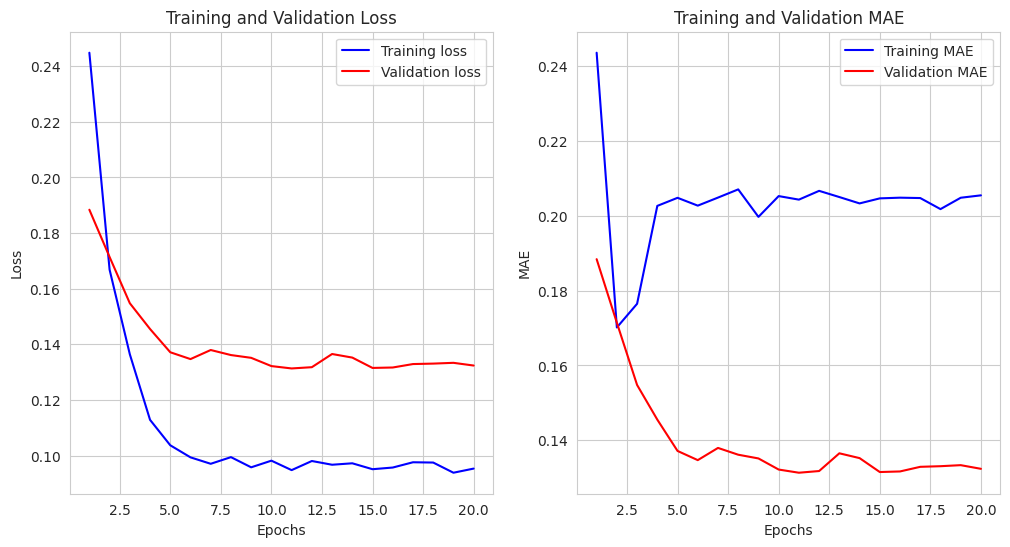

In [36]:
train_losses = []
val_losses = []
train_maes = []
val_maes = []

start_time = time.time()
best_val_loss = float('inf')
# Training loop
for epoch in range(200):
    model.train()
    running_loss = 0.0
    running_mae = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_mae += F.l1_loss(outputs, labels).item()

    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            val_mae += F.l1_loss(outputs, labels).item()

    running_loss /= len(train_loader)
    running_mae /= len(train_loader)
    val_loss /= len(val_loader)
    val_mae /= len(val_loader)

    # Early stopping and saving best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state_dict = model.state_dict()

        # Save the model
        torch.save(model.state_dict(), 'best_model.pth')

    if early_stopping(val_loss):
        print("Early stopping")
        break

    print(f"Epoch [{epoch+1}/200], Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Train MAE: {running_mae:.4f}, Val MAE: {val_mae:.4f}")

    train_losses.append(running_loss)
    val_losses.append(val_loss)
    train_maes.append(running_mae)
    val_maes.append(val_mae)

print("--- %.2f minutes ---" % ((time.time() - start_time)/60))

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting MAE
plt.subplot(1, 2, 2)
plt.plot(epochs, train_maes, 'b', label='Training MAE')
plt.plot(epochs, val_maes, 'r', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()

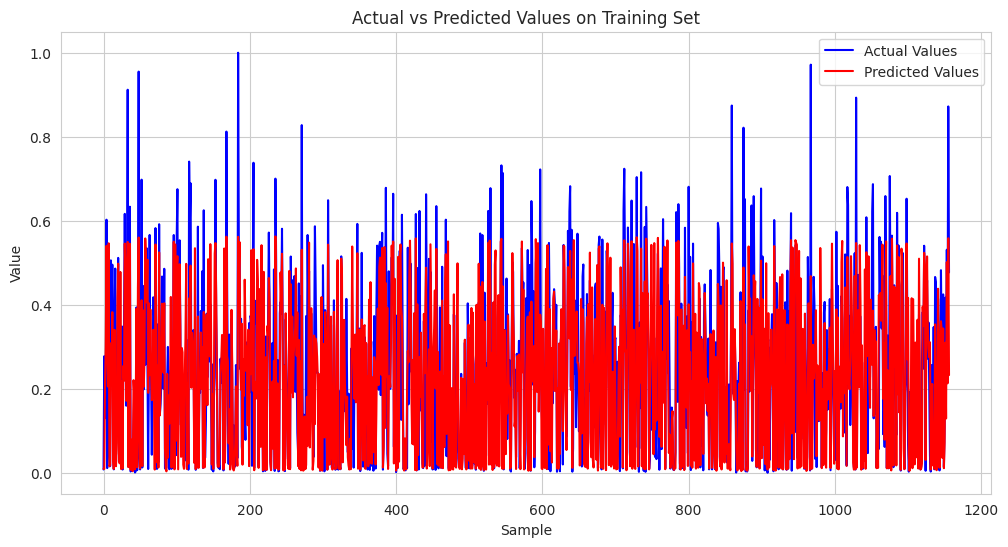

In [37]:
# Plot actual vs predicted values on the training set
model.eval()
actuals_train = []
predictions_train = []
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        actuals_train.extend(labels.cpu().numpy())
        predictions_train.extend(outputs.cpu().detach().numpy())

plt.figure(figsize=(12, 6))
plt.plot(actuals_train, label='Actual Values', color='blue')
plt.plot(predictions_train, label='Predicted Values', color='red')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values on Training Set')
plt.legend()
plt.show()



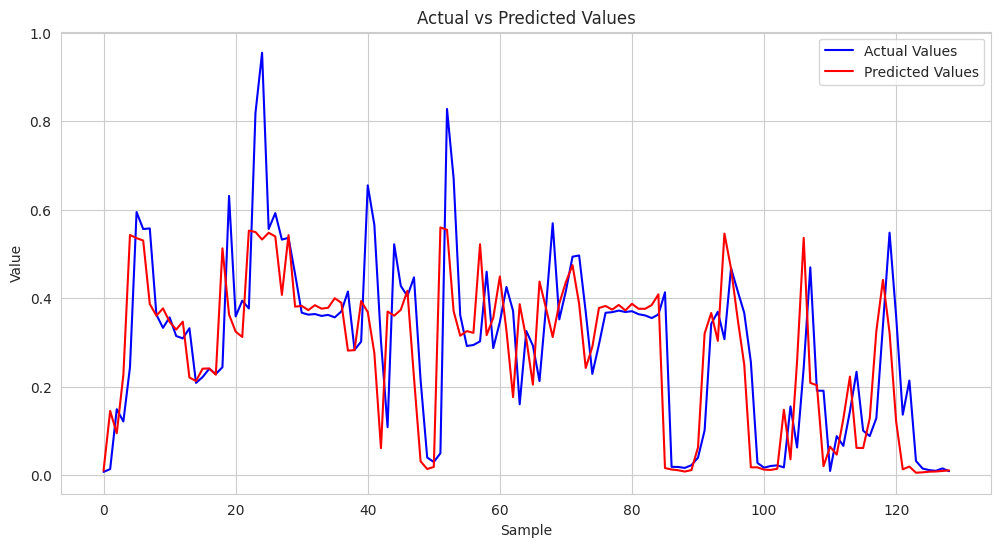

Number of actuals: 129
Number of predictions: 129


In [38]:
# Plot actual vs predicted values on the validation set
model.eval()
actuals = []
predictions = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        actuals.extend(labels.cpu().numpy())
        predictions.extend(outputs.cpu().detach().cpu().numpy())

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual Values', color='blue')
plt.plot(predictions, label='Predicted Values', color='red')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

print("Number of actuals:", len(actuals))
print("Number of predictions:", len(predictions))


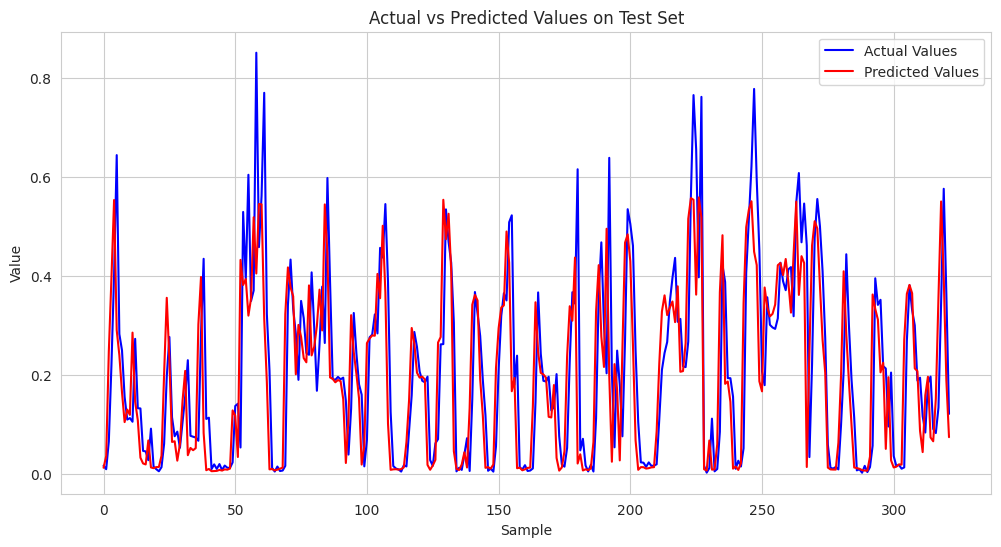

MAPE: 323.9051%, MAE: 0.2045, Accuracy: 78.2585%


In [40]:
import numpy as np
def calculate_mape(actuals, predictions):
    return np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100

def calculate_mae(actuals, predictions):
    return np.mean(np.abs(np.array(actuals) - np.array(predictions)))

def calculate_accuracy(actuals, predictions, threshold=0.5):
    actuals_binary = np.array(actuals) >= threshold
    predictions_binary = np.array(predictions) >= threshold
    return np.mean(actuals_binary == predictions_binary) * 100
# Plot actual vs predicted values on the test set
model.eval()
actuals_test = []
predictions_test = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        actuals_test.extend(labels.cpu().numpy())
        predictions_test.extend(outputs.cpu().detach().numpy())

plt.figure(figsize=(12, 6))
plt.plot(actuals_test, label='Actual Values', color='blue')
plt.plot(predictions_test, label='Predicted Values', color='red')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.show()


# Calculate and print the MAPE, MAE, and accuracy
mape = calculate_mape(actuals, predictions)
mae = calculate_mae(actuals, predictions)
accuracy = calculate_accuracy(actuals, predictions)
print(f"MAPE: {mape:.4f}%, MAE: {mae:.4f}, Accuracy: {accuracy:.4f}%")

In [47]:
# Calculate and print the test loss
test_loss = 0.0
num_batches = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        test_loss += loss.item()
        num_batches += 1

test_loss /= num_batches
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0919


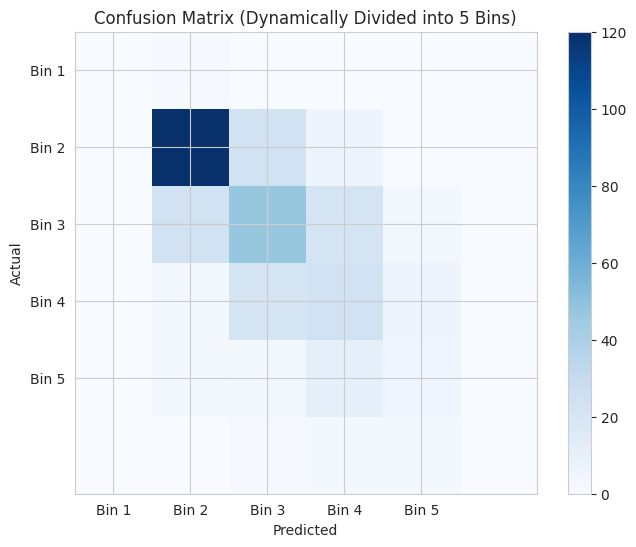

In [46]:
bin_edges = np.histogram_bin_edges(actuals_test, bins=5)
actuals_bins = np.digitize(actuals_test, bin_edges, right=True)
predictions_bins = np.digitize(predictions_test, bin_edges, right=True)

# Confusion matrix
conf_matrix = confusion_matrix(actuals_bins, predictions_bins)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Dynamically Divided into 5 Bins)')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(range(5), ['Bin ' + str(i+1) for i in range(5)])
plt.yticks(range(5), ['Bin ' + str(i+1) for i in range(5)])
plt.show()